# Projeto SuperComputação 2023.2

## Análise de Redes Sociais: encontrando a clique máxima em um grafo.

`Aluna : Letícia Coêlho Barbosa`

<img alt= "grafo" src = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/1200px-VR_complex.svg.png" width = "600px">

## **Sumário**

0. [Configuração](#configuracao)
1. [Inicialização](#inicializacao)
  
  1.1  [Geração de grafos](#gera-grafos)

2. [Abordagem Exaustiva local](#exaustiva-local)

3. [Abordagem busca exaustiva local com heuristica](#heuristica)

4. [Abordagem Exaustiva global](#exaustiva-global)

5. [Abordagem Exautiva global com OMP](#omp)

6. [Abordagem Exaustiva global com MPI](#mpi)

  6.1 [Arquivo de configuração para o Cluster](#slurm)

7. [Resultado Esperado](#resultado-esperado)

8. [Verificando desempenho dos Algoritimos](#desempenho)

  8.1 [Comparando Busca Exaustiva Local com Busca Exaustiva Heurística](#desempenho-1)
  
  8.2 [Comparando Busca Exaustiva Global e Busca Exaustiva com OMP](#desempenho-2)

  8.3 [Comparando MPI (Valores obtidos experimentalmente)** e Busca Exaustiva OMP](#desempenho-3)

  8.4 [Comparando todos os algorítimos](#desempenho-4)

9. [Esclarecimento e Conclusões Finais](#fim)

### 0. **Configuração** <a id="configuracao"></a>

In [1]:
# Remove possível repositório já existente
%cd "../.."
! rm -rf Find-MaximumClique-Graph

/


In [2]:
# Clonando repositorio com as implementações:
!git clone https://github.com/leticiacb1/Find-MaximumClique-Graph

Cloning into 'Find-MaximumClique-Graph'...
remote: Enumerating objects: 356, done.
remote: Total 356 (delta 0), reused 0 (delta 0), pack-reused 356
Receiving objects: 100% (356/356), 2.92 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [3]:
# Entrando na pasta
%cd Find-MaximumClique-Graph

/Find-MaximumClique-Graph


### 1. **Inicialização** <a id="inicializacao"></a>

In [4]:
# ----------------------
# ----- Parâmetros -----
# ----------------------

lista_de_vertices = [5, 25, 50, 75, 100, 125, 150]

lista_algoritimos = ["0-busca-exaustiva-local", "1-busca-exaustiva-heuristica" , "2-busca-exaustiva-global", "3-busca-exaustiva-omp", "4-busca-exaustiva-mpi"]

# Padrão de escrita fos arquivos de grafo.
init_file_name = "data/graphs/grafo-"
extension_file_name = ".txt"

nome_de_arquivos = [init_file_name + str(v) + extension_file_name  for v in lista_de_vertices]

#### 1.1 Gerando grafos <a id="gera-grafos"></a>

 [INFO] O pacote utils foi importado.
 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-25.txt'.



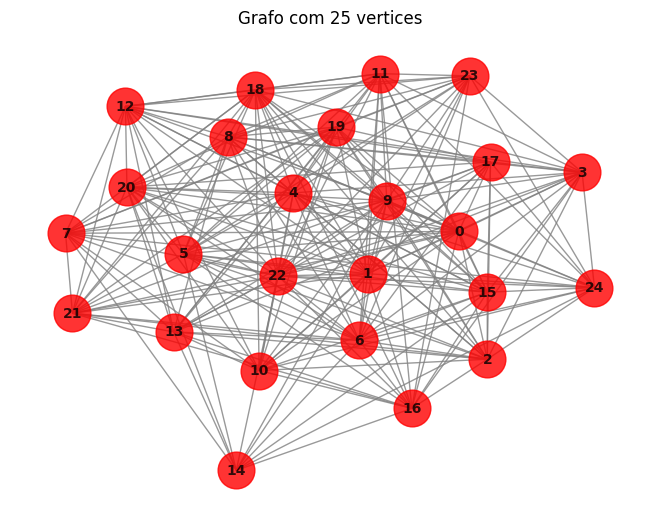

In [5]:
# --- Demonstração do uso ---

from src.python.utils.constroi_grafo import constroi_grafo

nome_arquivo = nome_de_arquivos[1]
num_vertices = lista_de_vertices[1]

save_fig_graph = "img/graphs/grafo-exemplo.png"

constroi_grafo(nome_arquivo, num_vertices, show = True, save_fig_graph = save_fig_graph)

In [6]:
# --- Gerando grafos ---

from src.python.utils.constroi_grafo import constroi_grafo

for filename , vertices in zip(nome_de_arquivos, lista_de_vertices):
  constroi_grafo(filename, vertices)

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-5.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-25.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-50.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-75.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-100.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-125.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-150.txt'.



In [7]:
# Verificando se os arquivos foram mesmo criados:
%cd data/graphs
!ls

/Find-MaximumClique-Graph/data/graphs
grafo-100.txt  grafo-150.txt  grafo-50.txt  grafo-75.txt
grafo-125.txt  grafo-25.txt   grafo-5.txt   grafo.txt


In [8]:
# Voltando para pasta principal:
%cd "../.."

/Find-MaximumClique-Graph



### 2. **Abordagem Exaustiva local** <a id="exaustiva-local"></a>

Método de otimização que explora iterativamente soluções em uma vizinhança local de uma solução corrente, buscando melhorias. A ideia fundamental é começar com uma solução inicial e, em seguida, realizar iterações, movendo-se para soluções vizinhas que prometem melhorar a solução corrente.


```cpp

#include<iostream>
#include<vector>
#include <fstream>
#include<algorithm>

#include "../utils/display-result.h"
#include "../utils/ler-grafo.h"

using namespace std;

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

vector<int> EncontrarCliqueMaximoLocal(vector<vector<int>> grafo, int numVertices) {
    /*
    * Calcula clique máximo local do grafo
    */

    vector<int> cliqueMaximo;
    vector<int> candidatos;

    // No inicio todos os nós são candidatos
    for (int i = 0; i < numVertices; ++i) {
        candidatos.push_back(i);
    }

    // Enquanto lista de candidados não vazia
    while(!candidatos.empty()){
        int v = candidatos.back();
        candidatos.pop_back();


        bool podeAdicionar = true;
        for (int u : cliqueMaximo) {
            if (grafo[u][v] == 0) {
                podeAdicionar = false;
                break;
            }
        }

        if (podeAdicionar) {
            cliqueMaximo.push_back(v);
            vector<int> novosCandidatos;

            for (int u : candidatos) {
                bool adjacenteATodos = true;

                for (int c : cliqueMaximo) {
                    if (grafo[u][c] == 0) {
                        adjacenteATodos = false;
                        break;
                    }
                }

                if (adjacenteATodos) {
                    novosCandidatos.push_back(u);
                }
            }

            candidatos = novosCandidatos;
        }
   }

   return cliqueMaximo;
}


// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

vector<int> main() {

    string nomeArquivo = "grafo.txt";
    int numVertices = 4;

    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);
    vector<int> cliqueMaximo =  EncontrarCliqueMaximoLocal(grafo,numVertices);

    displayResult("Busca Exaustiva Local", cliqueMaximo);

    return cliqueMaximo ;
}


```

In [9]:
!g++ -Wall -O3 -g \
    src/implementations/algorithm/0-busca-exaustiva-local.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 0-busca-exaustiva-local

In [10]:
!./0-busca-exaustiva-local data/graphs/grafo-25.txt 25

 ===== [Busca Exaustiva Local] ===== 

 > Clique Máxima encontrada : 25, 23, 21, 17, 16, 14, 13, 12
 > Tamanho : 8

### 3. **Abordagem busca exaustiva local com heuristica** <a id="heuristica"></a>

Podemos definir o grau de adjacencia de um grafo simples como:

> O grau de um vértice , com o grafo representado em uma matriz de adjacencia, é dado pela soma dos elementos de sua linha (ou coluna) correspondente. [1]

ou, similarmente, também pode ser definido como:

> O grau de um vértice v em um grafo G também pode
ser visto como a quantidade de arestas incidentes em
v. [2]

Para facilitar o entendimento desse conceito, observe o grafo abaixo apresentado:

<div align="center">
  <img alt="Exemplo de calculo de grau do nó" src="https://github.com/leticiacb1/Find-MaximumClique-Graph/blob/main/img/utils/calcula_grau_exemplo.png?raw=true" />
</div>

Temos que o grau dos vertices é dado pela quantidade de arestas ligadas a ele (no caso de um grafo não direcional, não faz diferença se essas arestas são de entrada ou de saída):

$$d(v1) = 2$$

$$d(v2) = 1$$

$$d(v3) = 3$$

$$d(v4) = 2$$

$$d(v5) = 0$$


É possível inferir que a estratégia de ordenar os vertices de acordo com o seu grau de adjacencia seja uma estratégia eficaz para melhorar o desempenho do algorítimo. Isso se deve ao fato de que os vértices com maiores graus de adjacência tendem a ter uma maior probabilidade de pertencer a clique máxima, visto que em um clique, todos os vértices estão concetados entre si.


[1] https://www.ibilce.unesp.br/Home/Departamentos/MatematicaAplicada/socorro4029/representa_grafos2.pdf

[2] https://www.facom.ufms.br/~fhvm/disciplinas/anteriores/2005/grafos/aula2.pdf

`Pseudo-Código`

Utilizando como base o pseudocódigo inicialmente fornecido (`Busca Exaustiva Local`), podemos pensar nas seguintes implemnetações para a ordenação pelo calculo de adjacência:

```cpp

Função calculaGrau(grafo, vertice):
    grau = 0
    
    para cada vizinho em grafo[nó]:
        se existe_aresta(vertice, vizinho):
            grau +=1
    retornar grau

Função OrdenarPorGrau(grafo, vertice1, vertice2):
    retorna calculaGrau(grafo, vertice2) - calculaGrau(grafo, vertice1)

Função EncontrarCliqueMaximaOrdenada(grafo, numVertices):
    cliqueMaxima = ListaVazia()
    candidatos = ListaDeNós()

    Para cada i de 0 até numVertices - 1 Faça
        Adicione i à lista de candidatos

    // Ordena lista de candidatos usando a função OrdenaPorGrau
    sort(candidatos, OrdenarPorGrau);

    Enquanto candidatos não estiver vazia Faça
        v = Último elemento de candidatos
        Remova o último elemento de candidatos

        podeAdicionar = Verdadeiro

        Para cada u em cliqueMaxima Faça
            Se grafo[u][v] == 0 Então
                podeAdicionar = Falso
                Pare o loop
            Fim Se
        Fim Para

        Se podeAdicionar
            Adicione v a cliqueMaxima
            novosCandidatos = ListaDeNós()

            Para cada u em candidatos Faça
                adjacenteATodos = Verdadeiro

                Para cada c em cliqueMaxima Faça
                    Se grafo[u][c] == 0 Então
                        adjacenteATodos = Falso
                        Pare o loop
                    Fim Se
                Fim Para

                Se adjacenteATodos
                    Adicione u a novosCandidatos
                Fim Se
            Fim Para

            // Ordena novos candidatos por grau
            sort(novosCandidatos, OrdenarPorGrau);

            candidatos = novosCandidatos
        Fim Se
    Fim Enquanto

    Retorne cliqueMaxima
Fim Função

```

In [11]:
!g++ -Wall -O3 -g \
    src/implementations/algorithm/1-busca-exaustiva-heuristica.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 1-busca-exaustiva-heuristica

In [12]:
!./1-busca-exaustiva-heuristica data/graphs/grafo-25.txt 25

 ===== [Busca Exaustiva Local com Heuristica] ===== 

 > Clique Máxima encontrada : 9, 17, 3, 23, 22, 21, 14, 1, 2
 > Tamanho : 9

### 4. **Abordagem Exaustiva global** <a id="exaustiva-global"></a>

Método de resolução de problemas que explora todas as possíveis soluções em um espaço de busca para encontrar a melhor solução. Isso implica examinar todas as combinações possíveis, o que pode ser impraticável para problemas com espaços de busca muito grandes.

```cpp
#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>

#include "../utils/display-result.h"
#include "../utils/ler-grafo.h"

using namespace std;

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                return false;
            }
        }
    }
    return true;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;
    for (int u : candidatos) {
        if (grafo[v][u] == 1) {
            novosCandidatos.push_back(u);
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

int main(int argc, char* argv[]) {

    if(argc != 3 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 3 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices = stoi(argv[2]);

    // ------ Lê Grafo ------
    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // ------ Clique Máximo ------
    // Gera candidatos inicias (todos os vertices)

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    // ------ Mostra na tela ------
    displayResult("Busca Exaustiva Global", cliqueMaximo);

    return 0;
}

```


In [13]:
!g++ -Wall -O3 -g \
    src/implementations/algorithm/2-busca-exaustiva-global.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 2-busca-exaustiva-global

In [14]:
!./2-busca-exaustiva-global data/graphs/grafo-5.txt 5

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : 5, 4, 2, 1
 > Tamanho : 4

### 5. **Abordagem Exautiva global com OMP** <a id="omp"></a>

OpenMP permite que os desenvolvedores criem aplicações paralelas em sistemas de memória compartilhada, como computadores multicore.

```cpp
#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>
#include <omp.h>

#include "../utils/display-result.h"
#include "../utils/ler-grafo.h"

using namespace std;

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    bool ehClique = true;

    #pragma omp parallel for shared(ehClique) collapse(2)
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                #pragma omp critical
                {
                  ehClique = false;
                }
            }
        }
    }

    return ehClique;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;

    #pragma omp parallel for
    for (int u : candidatos) {

        if (grafo[v][u] == 1) {
            #pragma omp critical
            {
              novosCandidatos.push_back(u);
            }
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

int main(int argc, char* argv[]) {

    if(argc != 3 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 3 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices = stoi(argv[2]);

    // ------ Lê Grafo ------

    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // ------ Clique Máximo ------
    // Gera candidatos inicias (todos os vertices)

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    // ------ Mostra na tela ------
    displayResult("Busca Exaustiva Global", cliqueMaximo);

    return 0;
}

```

In [15]:
!g++ -fopenmp  -Wall -O3 -g \
    src/implementations/algorithm/3-busca-exaustiva-omp.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 3-busca-exaustiva-omp

In [16]:
!./3-busca-exaustiva-omp data/graphs/grafo-5.txt 5

 ===== [Busca Exaustiva OMP] ===== 

 > Clique Máxima encontrada : 5, 4, 1, 2
 > Tamanho : 4

### 6. **Abordagem Exaustiva global com MPI** <a id="mpi"></a>

MPI (Message Passing Interface) permite que os desenvolvedores criem aplicações paralelas que trocam mensagens entre processos em diferentes nós de um sistema distribuído.

```cpp

#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>
#include <mpi.h>
#include <chrono>

#include "../utils/display-result.h"
#include "../utils/ler-grafo.h"

using namespace std;

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                return false;
            }
        }
    }
    return true;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;
    for (int u : candidatos) {
        if (grafo[v][u] == 1) {
            novosCandidatos.push_back(u);
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

int main(int argc, char** argv) {

    // ------ Parametros ------
  
    string nomeArquivo = argv[1];
    int numVertices = stoi(argv[2]);

    vector<vector<int>> grafo;
    vector<int> cliqueMaximoGlobal, cliqueMaximoParcial;

    // Declara variáveis de tempo
    chrono::high_resolution_clock::time_point start;
    chrono::high_resolution_clock::time_point end;

    // ------ Instancia MPI ------

    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);


    if(rank == 0 ){

      if(argc != 3 ){
        cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 3 argumentos | Recebeu = " << argc << " argumentos \n";
        return 1;
      }

      start = chrono::high_resolution_clock::now();

      // ------ Processo Pai ------
      // ------ Lê Grafo ------
      grafo = LerGrafo(nomeArquivo, numVertices);

      // --- Compartilha o número de vertices com os processos ---
      MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

      // --- Envia parte do grafo para os processos ---

      for (int i = 0; i < numVertices; ++i) {
        MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
      }

    }else{
      // ------ Processos filhos ------
      // Recebe número de vértices

      // Outros processos recebem o número de vértices
      MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

      // Alocar espaço para receber a parte do grafo
      grafo.resize(numVertices, vector<int>(numVertices, 0));

      // Receber a parte do grafo do processo raiz
      for (int i = 0; i < numVertices; ++i) {
          MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
      }
    }

    // ------------ Executado por todos ------------
    // Gera candidatos inicias (todos os vertices)
    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    if(rank != 0){
      // Envia resultados parciais obtidos com aquela porção do grafo:
      MPI_Send(cliqueMaximo.data(), numVertices, MPI_INT, 0, 0, MPI_COMM_WORLD);

    }else{
      // Atualiza partialCliqueMaximo com tamanho do número de vertices:
      vector<int> partialCliqueMaximo(numVertices, 0);

      for (int i = 1; i < size; ++i) {
        MPI_Recv(partialCliqueMaximo.data(), numVertices, MPI_INT, i, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Atualizar clique máximo global se necessário
        if (partialCliqueMaximo.size() > cliqueMaximo.size() && Clique(partialCliqueMaximo, grafo)) {
            cliqueMaximo = partialCliqueMaximo;
        }
      }

      // ------ Mostra na tela ------
      displayResult("Busca Exaustiva MPI", cliqueMaximo);

      end = chrono::high_resolution_clock::now();
      chrono::duration<double> delta = end - start;

      cout << "\n [TIMER] " << delta.count() << " segundos." << endl;

    }

    MPI_Finalize();
    return 0;
}

```

In [17]:
!mpic++ -o 4-busca-exaustiva-mpi src/implementations/algorithm/4-busca-exaustiva-mpi.cpp \
                                 src/implementations/utils/display-result.cpp\
                                 src/implementations/utils/ler-grafo.cpp

In [18]:
!mpirun --allow-run-as-root -np 1 ./4-busca-exaustiva-mpi data/graphs/grafo-5.txt 5

 ===== [Busca Exaustiva MPI] ===== 

 > Clique Máxima encontrada : 5, 4, 2, 1
 > Tamanho : 4
 [TIMER] 0.000154037 segundos.


#### 6.1 **Arquivo de configuração para o Cluster** <a id="slurm"></a>

Para roda rno cluster, dentro da pasta `Find-MaximumClique-Graph` executei para a compilação:

```
[leticia@sms-host Find-MaximumClique-Graph]$ mpic++ -o src/implementations/  
algorithm/4-busca-exaustiva-mpi src/implementations/algorithm/           
4-busca-exaustiva-mpi.cpp src/implementations/utils/display-result.cpp src/implementations/utils/ler-grafo.cpp
```

No arquivo de configuração, optei por utilizar os parãmetros nodes e ntask como o mostrado a baixo:


```bash
#!/bin/bash  
#SBATCH --job-name=4-busca-exaustiva-mpi-5-vertices
#SBATCH --nodes=2
#SBATCH --tasks=2    
#SBATCH --partition=normal

#SBATCH --output=../outputs/%x.%j.out
#SBATCH --error=../outputs/%x.%j.err

mpirun -np 2 ./../../src/implementations/algorithm/4-busca-exaustiva-mpi ../../data/graphs/grafo-5.txt 5
```

Dentro da pasta `configuration/slurm` executei os comandos que possibilitaram rodar o código do MPI , implementado na busca exaustiva, em `batch` :

```
sbatch slurm-file.conf
```

Os outputs foram salvos na pasta `configuration/outputs`.

In [19]:
# ----- MPI  Obtido Experimentalmente -----
lista_cliqueMaximo_mpi = [[5, 4, 3],
                          [25, 23, 15, 9, 8, 5, 4, 2],
                          [48, 46, 41, 38, 31, 29, 27, 22, 20, 7, 6],
                          [74, 71, 65, 64, 58, 54, 51, 41, 40, 35, 27, 26, 20],
                          [95, 93, 79, 76, 72, 55, 53, 47, 43, 27, 22, 15, 9, 4, 2],
                          [120, 115, 101, 91, 87, 75, 70, 65, 64, 53, 44, 36, 29, 19, 18, 1],
                          [142, 134 ,132 , 120, 115, 101, 91, 87, 75, 70, 65, 64, 53, 44, 36, 24]]

lista_tamanho_mpi = [len(cliques) for cliques in lista_cliqueMaximo_mpi]
lista_tempo_mpi = [0.0130099, 0.0269171, 0.155679, 2.58538, 18.7041, 164.605, 559.201]

### 7. **Resultado Esperado** <a id="resultado-esperado"></a>

In [20]:
# Comparando resultado obtido via biblioteca do python:

from src.python.utils.clique_maximo_resposta import clique_maximo_resposta

nome_arquivo = "/Find-MaximumClique-Graph/data/graphs/grafo-5.txt"
clique_maximo_resposta(nome_arquivo, debug = True)

 ===== [ RESPOSTAS ] ===== 

 > Cliques maximais encontradas:
['1', '4', '2', '5']
['1', '4', '2', '3']

 > Clique máxima encontrada: ['1', '4', '2', '5']

 > Clique máxima tamanho: 4


['1', '4', '2', '5']

###8. **Verificando desempenho dos Algoritimos** <a id="desempenho"></a>

In [21]:
#   ---------------------------------
#   ---- Monta lista de comandos ----
#   ---------------------------------

#   Para executar o arquivo:
#   > ./executavel grafo.txt num_vetices

dic_comandos = {}

for algoritimo in lista_algoritimos:
  aux = []
  for v , grafo in zip(lista_de_vertices , nome_de_arquivos):
    aux.append([f"./{algoritimo}" , f"{grafo}",  f"{v}"])

  dic_comandos[algoritimo] = aux

#### 8.1 **Comparando Busca Exaustiva Local com Busca Exaustiva Heurística** <a id="desempenho-1"></a>

In [22]:
#   ---------------------------------------
#   -------- Busca Exaustiva Local --------
#   ---------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-local.csv'
algoritimo = 'busca-exaustiva-local'
lista_commandos = dic_comandos['0-busca-exaustiva-local']

df_exaustiva_local = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_local

,Algoritimo,Vertices,Clique Esperado,Clique Calculado,Tamanho Esperado,Tamanho Calculado,Time (s),Mesmo Tamanho ?
0,busca-exaustiva-local,5,"[1, 4, 2, 5]","[ 5, 4, 2, 1]",4,4,0.002097,Sim
1,busca-exaustiva-local,25,"[2, 17, 23, 14, 1, 3, 22, 9, 11, 5]","[ 25, 23, 21, 17, 16, 14, 13, 12]",10,8,0.002038,Não
2,busca-exaustiva-local,50,"[45, 38, 2, 22, 9, 3, 20, 15, 50, 12, 5]","[ 50, 49, 47, 42, 39, 37, 35, 17, 1]",11,9,0.002468,Não
3,busca-exaustiva-local,75,"[23, 74, 54, 58, 46, 61, 35, 71, 9, 51, 25, 53]","[ 75, 74, 73, 69, 68, 65, 62, 25, 10]",12,9,0.002879,Não
4,busca-exaustiva-local,100,"[42, 82, 32, 59, 31, 55, 67, 5, 81, 1, 86, 90,...","[ 100, 98, 96, 93, 91, 70, 66, 54, 44]",16,9,0.002774,Não
5,busca-exaustiva-local,125,"[50, 34, 36, 101, 90, 112, 77, 119, 28, 114, 3...","[ 125, 121, 120, 119, 112, 106, 102, 90...",16,12,0.003055,Não
6,busca-exaustiva-local,150,"[46, 89, 149, 117, 4, 142, 70, 10, 43, 15, 122...","[ 150, 147, 145, 144, 139, 126, 123, 12...",17,10,0.003800,Não


In [23]:
#   --------------------------------------------
#   -------- Busca Exaustiva Heuristica --------
#   --------------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-heuristic.csv'
algoritimo = 'busca-exaustiva-heuristic'
lista_commandos = dic_comandos['1-busca-exaustiva-heuristica']

df_exaustiva_heuristica = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_heuristica

,Algoritimo,Vertices,Clique Esperado,Clique Calculado,Tamanho Esperado,Tamanho Calculado,Time (s),Mesmo Tamanho ?
0,busca-exaustiva-heuristic,5,"[1, 4, 2, 5]","[ 5, 4, 1, 2]",4,4,0.002911,Sim
1,busca-exaustiva-heuristic,25,"[2, 17, 23, 14, 1, 3, 22, 9, 11, 5]","[ 9, 17, 3, 23, 22, 21, 14, 1, 2]",10,9,0.002027,Não
2,busca-exaustiva-heuristic,50,"[45, 38, 2, 22, 9, 3, 20, 15, 50, 12, 5]","[ 20, 50, 21, 5, 9, 43, 38, 15, 1, 2]",11,10,0.002502,Não
3,busca-exaustiva-heuristic,75,"[23, 74, 54, 58, 46, 61, 35, 71, 9, 51, 25, 53]","[ 21, 17, 52, 12, 63, 65, 70, 39, 1, 2]",12,10,0.002828,Não
4,busca-exaustiva-heuristic,100,"[42, 82, 32, 59, 31, 55, 67, 5, 81, 1, 86, 90,...","[ 10, 14, 34, 70, 19, 42, 12, 82, 94, ...",16,12,0.021093,Não
5,busca-exaustiva-heuristic,125,"[50, 34, 36, 101, 90, 112, 77, 119, 28, 114, 3...","[ 36, 122, 90, 96, 81, 50, 37, 58, 52,...",16,13,0.004655,Não
6,busca-exaustiva-heuristic,150,"[46, 89, 149, 117, 4, 142, 70, 10, 43, 15, 122...","[ 86, 133, 53, 26, 21, 49, 77, 78, 12,...",17,12,0.006027,Não


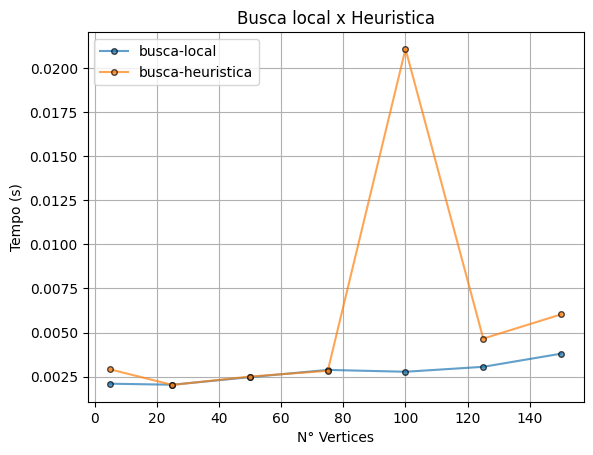

<Figure size 640x480 with 0 Axes>

In [24]:
#   --------------------------------------------
#   ------ Grafico de Comparação Temporal ------
#   --------------------------------------------

from src.python.utils.desenha_grafico import desenha_grafico

filename = 'img/graphs/compare-local-heuristic.png'
title = 'Busca local x Heuristica'
x_label = 'N° Vertices'
y_label = 'Tempo (s)'

list_x = lista_de_vertices
list_y = [df_exaustiva_local['Time (s)'] , df_exaustiva_heuristica['Time (s)']]

list_labels = ['busca-local', 'busca-heuristica']

desenha_grafico(filename, title, x_label, y_label, list_x,list_y, list_labels)

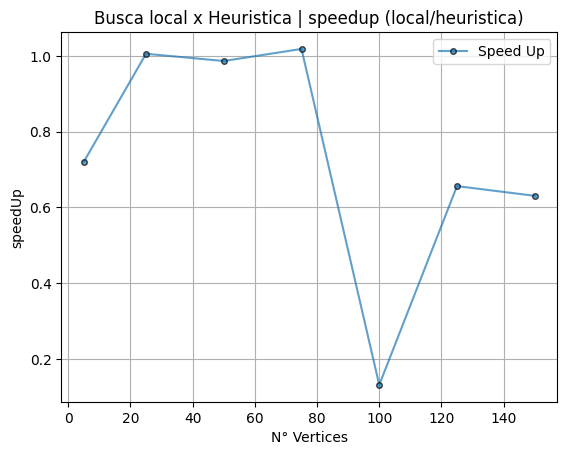

<Figure size 640x480 with 0 Axes>

In [25]:
#   --------------------------------------------
#   ----------- Grafico de Speed Up ------------
#   --------------------------------------------

from src.python.utils.desenha_grafico import desenha_grafico

filename = 'img/graphs/compare-local-heuristic-speedUp.png'
title = 'Busca local x Heuristica | speedup (local/heuristica)'
x_label = 'N° Vertices'
y_label = 'speedUp'

list_x = lista_de_vertices
list_y = [df_exaustiva_local['Time (s)']/df_exaustiva_heuristica['Time (s)']]

list_labels = ['Speed Up']

desenha_grafico(filename, title, x_label, y_label, list_x,list_y, list_labels)

#### 8.2 **Comparando Busca Exaustiva Global e Busca Exaustiva com OMP** <a id="desempenho-2"></a>

In [26]:
#   ----------------------------------------
#   -------- Busca Exaustiva Global --------
#   ----------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-global.csv'
algoritimo = 'busca-exaustiva-global'
lista_commandos = dic_comandos['2-busca-exaustiva-global']

df_exaustiva_global = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_global

,Algoritimo,Vertices,Clique Esperado,Clique Calculado,Tamanho Esperado,Tamanho Calculado,Time (s),Mesmo Tamanho ?
0,busca-exaustiva-global,5,"[1, 4, 2, 5]","[ 5, 4, 2, 1]",4,4,0.004060,Sim
1,busca-exaustiva-global,25,"[2, 17, 23, 14, 1, 3, 22, 9, 11, 5]","[ 23, 22, 17, 14, 11, 9, 5, 3, 2, 1]",10,10,0.002264,Sim
2,busca-exaustiva-global,50,"[45, 38, 2, 22, 9, 3, 20, 15, 50, 12, 5]","[ 50, 47, 43, 37, 35, 29, 21, 15, 9, ...",11,11,0.013457,Sim
3,busca-exaustiva-global,75,"[23, 74, 54, 58, 46, 61, 35, 71, 9, 51, 25, 53]","[ 75, 74, 73, 69, 65, 59, 51, 39, 35, ...",12,12,0.150199,Sim
4,busca-exaustiva-global,100,"[42, 82, 32, 59, 31, 55, 67, 5, 81, 1, 86, 90,...","[ 90, 86, 82, 81, 67, 59, 55, 42, 41, ...",16,16,1.802381,Sim
5,busca-exaustiva-global,125,"[50, 34, 36, 101, 90, 112, 77, 119, 28, 114, 3...","[ 119, 114, 113, 112, 101, 99, 91, 90, ...",16,16,10.516131,Sim
6,busca-exaustiva-global,150,"[46, 89, 149, 117, 4, 142, 70, 10, 43, 15, 122...","[ 149, 147, 143, 142, 136, 122, 117, 95...",17,17,46.262233,Sim


In [ ]:
#   ----------------------------------------
#   ---------- Busca Exaustiva OMP ---------
#   ----------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-omp.csv'
algoritimo = 'busca-exaustiva-omp'
lista_commandos = dic_comandos['3-busca-exaustiva-omp']

df_exaustiva_omp = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = True)
df_exaustiva_omp

 [COMANDO] ['./3-busca-exaustiva-omp', 'data/graphs/grafo-5.txt', '5'] | [VERTICES] 5


 [TIMER] 0.006650167999396217 segundos


 [COMANDO] ['./3-busca-exaustiva-omp', 'data/graphs/grafo-25.txt', '25'] | [VERTICES] 25


 [TIMER] 0.7751601710006071 segundos


 [COMANDO] ['./3-busca-exaustiva-omp', 'data/graphs/grafo-50.txt', '50'] | [VERTICES] 50


 [TIMER] 20.813385616999767 segundos


 [COMANDO] ['./3-busca-exaustiva-omp', 'data/graphs/grafo-75.txt', '75'] | [VERTICES] 75


 [TIMER] 247.38264114600042 segundos




In [ ]:
#   --------------------------------------------
#   ------ Grafico de Comparação Temporal ------
#   --------------------------------------------

from src.python.utils.desenha_grafico import desenha_grafico

filename = 'img/graphs/compare-global-omp.png'
title = 'Busca Global x OMP'
x_label = 'N° Vertices'
y_label = 'Tempo (s)'

list_x = lista_de_vertices
list_y = [df_exaustiva_global['Time (s)'] , df_exaustiva_omp['Time (s)']]

list_labels = ['busca-global', 'busca-omp']

desenha_grafico(filename, title, x_label, y_label, list_x,list_y, list_labels)

In [ ]:
#   --------------------------------------------
#   ----------- Grafico de Speed Up ------------
#   --------------------------------------------

from src.python.utils.desenha_grafico import desenha_grafico

filename = 'img/graphs/compare-global-omp-speedUp.png'
title = 'Busca Global x OMP | speedup (global/omp)'
x_label = 'N° Vertices'
y_label = 'speedUp'

list_x = lista_de_vertices
list_y = [df_exaustiva_global['Time (s)']/df_exaustiva_omp['Time (s)']]

list_labels = ['Speed Up']

desenha_grafico(filename, title, x_label, y_label, list_x,list_y, list_labels)

#### 8.3 **Comparando MPI (Valores obtidos experimentalmente) e Busca Exaustiva OMP** <a id="desempenho-3"></a>

In [ ]:
# Montando a lista de clique máximo obtida para cada quantidade de vertices
# o arquivo .slurm foi configurado como o mostrado anteriormente.

from src.python.utils.clique_maximo_resposta import clique_maximo_resposta
import pandas as pd

# ----- Parâmetros -----
arquivo_csv = 'data/stats_busca-mip.csv'
algoritimo = 'busca-exaustiva-mip'
lista_commandos = dic_comandos['4-busca-exaustiva-mpi']

lista_nome_algoritimo = len(lista_de_vertices)*['busca-exaustiva-mpi']

# ----- MPI  Obtido -----
lista_cliqueMaximo_mpi = [[5, 4, 3],
                          [25, 23, 15, 9, 8, 5, 4, 2],
                          [48, 46, 41, 38, 31, 29, 27, 22, 20, 7, 6],
                          [74, 71, 65, 64, 58, 54, 51, 41, 40, 35, 27, 26, 20],
                          [95, 93, 79, 76, 72, 55, 53, 47, 43, 27, 22, 15, 9, 4, 2],
                          [120, 115, 101, 91, 87, 75, 70, 65, 64, 53, 44, 36, 29, 19, 18, 1],
                          [142, 134 ,132 , 120, 115, 101, 91, 87, 75, 70, 65, 64, 53, 44, 36, 24]]

lista_tamanho_mpi = [len(cliques) for cliques in lista_cliqueMaximo_mpi]

# ----- Python Esperado -----
lista_valores_esperados = []
lista_tamanho_esperado = []
for filename_grafo in nome_de_arquivos:
  esperado = clique_maximo_resposta(filename_grafo)
  size_esperado = len(esperado)

  lista_valores_esperados.append(esperado)
  lista_tamanho_esperado.append(size_esperado)

lista_mesmo_tamanho = []
for v in range(len(lista_de_vertices)):
  lista_mesmo_tamanho.append("Sim" if (len(lista_valores_esperados[v]) == len(lista_cliqueMaximo_mpi[v])) else "Não")

# ---- Monta dataframe ----
dados = {
    'Algoritimo': lista_nome_algoritimo ,
    'Vertices' : lista_de_vertices,
    'Clique Esperado': lista_valores_esperados,
    'Clique Calculado': lista_cliqueMaximo_mpi,
    'Tamanho Esperado':  lista_tamanho_esperado,
    'Tamanho Calculado': lista_tamanho_mpi,
    f'Time (s) [{algoritimo}]': lista_tempo_mpi,
    'Mesmo Tamanho ?': lista_mesmo_tamanho
}

df_exaustiva_mpi = pd.DataFrame(dados)
df_exaustiva_mpi.to_csv(arquivo_csv)

df_exaustiva_mpi

In [ ]:
#   ---------------------------------------------------------------------------------------
#   --------- Grafico de Comparação Temporal Busca Exaustiva MPI vs Exaustiva OMP  --------
#   ---------------------------------------------------------------------------------------

# Montando a lista de tempo obtida para cada quantidade de vertices
# o arquivo .slurm foi configurado como o mostrado anteriormente.

filename = 'img/graphs/compare-mpi-omp.png'
title = ' Exaustiva MPI vs Exaustiva OMP'
x_label = 'N° Vertices'
y_label = 'Tempo (s)'

list_x = lista_de_vertices
list_y = [lista_tempo_mpi , df_exaustiva_omp['Time (s)']]

list_labels = ['busca-exaustiva-mpi', 'busca-exaustiva-omp']

desenha_grafico(filename, title, x_label, y_label, list_x,list_y, list_labels)

#### 8.4 **Comparando todos os algorítimos** <a id="desempenho-4"></a>

In [ ]:
#   --------------------------------------------
#   ------ Grafico de Comparação Temporal ------
#   --------------------------------------------

from src.python.utils.desenha_grafico import desenha_grafico

filename = 'img/graphs/compare-all.png'
title = ' Local x Heuristica x Global x OMP X MPI'
x_label = 'N° Vertices'
y_label = 'Tempo (s)'

list_x = lista_de_vertices
list_y = [df_exaustiva_local['Time (s)']  , df_exaustiva_heuristica['Time (s)']  , df_exaustiva_global['Time (s)'] , df_exaustiva_omp['Time (s)'], lista_tempo_mpi]

list_labels = ['busca-local' ,'heuristica', 'busca-global', 'busca-omp', 'busca-mpi']

desenha_grafico(filename, title, x_label, y_label, list_x,list_y, list_labels)

### 9. **Esclarecimento e Conclusões Finais**

`Melhorias`

1.   O algorítimo inicialmente construído a partir do pseudo-código *(seção 2)*, por não está encontrando a solução máxima global ainda poderia ser escalonado para número de vértices superior ao utilizado nesse projeto, isso porém incapacitaria que o omp roda-se em tempo hábil (15min).

2.   A quantidade de vértices utilizados poderia ser maior, o que poderia alterado o desempenho dos algorítimos visto.

3.   Uso de mais algorítimos para comparação de desempenho como ,por exemplo ,implementar MPI, OMP e busca exaustiva no código exaustivo com heurística. O que contribuiria para maior riqueza de comparação/estudo e desempenho do problema abordado.

`Desempenho dos algorítimos`

1.    Esperava-se um tempo maior na implementação `Busca Exaustiva` do que na implmentação `Busca Exaustiva com Heuristica`, o que porém não foi observado.

      Alguns motivos podem ter levar a isso, como por exemplo:

      *a)* `Mal-condição`: Algumas instâncias de problemas podem ser mal-condicionadas para certas heurísticas. Problemas mal-condicionados podem levar a convergência lenta ou soluções subótimas.

      *b)* `Características do programa`: Alguns problemas podem não se beneficiar significativamente do uso de heurísticas.

      *c)* ``Implementação ineficiente` : A implementação da heurística pode ser ineficiente, envolvendo algoritmos complexos ou operações computacionais pesadas que impactam negativamente o desempenho. Isso poderia ocorre devido a complexidade do `sorted` realizado na lista de candidatos.


2.    Esperava-se um tempo maior na implementação `Busca Exaustiva` do que na implmentação `Busca Exaustiva com OMP`, o que porém não foi observado.

      Alguns motivos podem ter levar a isso, como por exemplo:

      *a)* `Implementação Recursiva` : Se um algoritmo possui uma estrutura fortemente recursiva e muitas relações interdependentes, a paralelização pode não resultar em melhorias significativas de desempenho. Além disso, implementações recursivas frequentemente geram uma grande quantidade de chamadas de função na pilha, introduzindo um overhead substancial e impactando adversamente o desempenho.

      *b)* `Gasto para sincronização das threads` : Se a implementação paralela envolve muita concorrência e sincronização entre threads, isso pode levar a bloqueios e espera excessiva, anulando os benefícios da paralelização.

      *c)* `Granularidade inadequada`: o trabalho dividido entre as threads pode estar inadequada. Se o tamanho do trabalho atribuído a cada thread for muito pequeno, o overhead da paralelização pode superar os benefícios.
